In [1]:
import pandas as pd
from collections import Counter
from sklearn.svm import SVC
from sklearn.model_selection import KFold,cross_validate,train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import average_precision_score,recall_score
import matplotlib.pyplot as plt


# #extract the data
raw_df = pd.read_csv("../BitcoinHeistData.csv")
cleaned_df = raw_df.copy()
cleaned_df['class']=np.array([0 if x=='white' else 1 for x in cleaned_df.pop('label')])

cleaned_df.pop("address")
cleaned_df.pop("year")
cleaned_df.pop("day")

# cleaned_df.pop("looped")
eps=0.001 # 0 => 0.1¢
cleaned_df['Log income'] = np.log(cleaned_df.pop('income')+eps)
cleaned_df['Log weight'] = np.log(cleaned_df.pop('weight')+eps)
print(cleaned_df.head(5))

#summarize the data distribution
y=np.array(cleaned_df['class'])
X=np.array(cleaned_df.iloc[:,:-1])
print(Counter(y))

#rescale data
scaler = StandardScaler()
X = scaler.fit_transform(X)


#define the undersampling method
under = RandomUnderSampler(sampling_strategy=0.5)



   length  count  looped  neighbors  class  Log income  Log weight
0      18      1       0          2      1   18.421181   -4.674163
1      44      1       0          1      1   18.420681   -6.689310
2       0      1       0          2      1   19.113828    0.001000
3      72      1       0          2      1   18.081003   -5.317245
4     144    456       0          1      1   19.113828   -2.605741
Counter({0: 2875284, 1: 41413})


NameError: name 'recall_train_score_list' is not defined

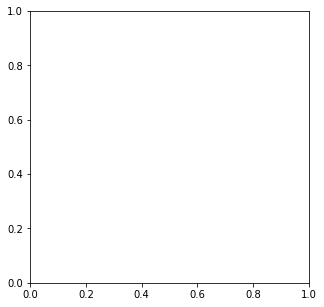

In [2]:
##cross validation to find out the best kernel to train the model###
t=7
cv = KFold(n_splits=t,shuffle=True)
AP_train_score_list=[]
AP_test_score_list=[]

kernels=['linear','poly','rbf','sigmoid']
# parameters=(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)[source]
for kernel in kernels:
    svm = SVC(gamma='auto',kernel=kernel,probability=True)
    steps = [('under',under),('model',svm)]
    pipeline = Pipeline(steps=steps)
    scores =  cross_validate(pipeline, X, y, scoring=['average_precision'], cv=cv, n_jobs=-1,return_train_score=True)
    
    AP_train_score_list.append(sum(scores['train_average_precision'])/t)
    AP_test_score_list.append(sum(scores['test_average_precision'])/t)
m = len(kernels)
# #generate Fig_0,Fig_1
fig_0, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
axs.plot(kernels,AP_train_score_list,"r^",linestyle = "--", label='training data')
axs.plot(kernels,AP_test_score_list,"b^",linestyle = "--",label='test data')
axs.set_xlabel("Kernels")
axs.set_ylabel("AP_score")
axs.legend()
fig_0.suptitle("Fig_1.4.0: AP_score(SVM)")
fig_0.savefig("SVM_fig_1.4_tunning:AP_score.png")




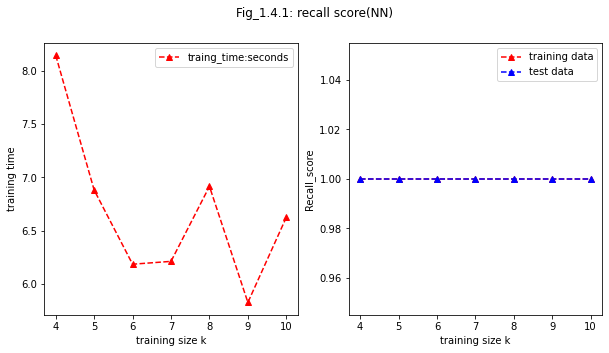

In [5]:
###############Apply kernel=linear to train the model##################
Recall_train_score=[]
Recall_test_score=[]
training_time = []

for k in range(4,11):
    cv = KFold(n_splits=k,shuffle=True)
    svm = SVC(gamma='auto',kernel='linear',probability=True)
    steps = [('under',under),('model',svm)]
    pipeline = Pipeline(steps=steps)
    scores =  cross_validate(pipeline, X, y, scoring=['recall'], cv=cv, n_jobs=-1,return_train_score=True)
    Recall_train_score.append(sum(scores['train_recall'])/k)
    Recall_test_score.append(sum(scores['test_recall'])/k)
    training_time.append(sum(scores['fit_time'])/k)

#generate Fig_1.4.1 learning curves with different training size
K= range(4,11)
fig_1, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
axs[0].plot(K,training_time,"r^",linestyle = "--",label="traing_time:seconds")
axs[0].set_xlabel("training size k")
axs[0].set_ylabel("training time")
axs[1].plot(K,Recall_train_score,"r^",linestyle = "--",label='training data')
axs[1].plot(K,Recall_test_score,"b^",linestyle = "--",label='test data')
axs[1].set_xlabel("training size k")
axs[1].set_ylabel("Recall_score")
axs[0].legend()
axs[1].legend()
fig_1.suptitle("Fig_1.4.1: recall score(NN)")
fig_1.savefig("NN_fig_1.4_trainnig:learning curves.png")
    

In [6]:
##################prediction results, generate the data in table1.4.0#########
cv = KFold(n_splits=9,shuffle=True)
svm = SVC(gamma='auto',kernel='linear',probability=True)
steps = [('under',under),('model',svm)]
pipeline = Pipeline(steps=steps)
scores =  cross_validate(pipeline, X, y, scoring=['recall','average_precision'], cv=cv, n_jobs=-1,return_train_score=True)
print("The AP scores on training set and test set are",sum(scores['train_average_precision'])/9,sum(scores['test_average_precision'])/9)
print("The Recall scores on training set and test set are",sum(scores['train_recall'])/9,sum(scores['test_recall'])/9)


/Users/we/miniconda3/envs/ml_env/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


The AP scores on training set and test set are 2.25 2.25
The Recall scores on training set and test set are 2.25 2.25


In [22]:
cv = KFold(n_splits=9,shuffle=True)
svm = SVC(gamma='auto',kernel='sigmoid',probability=True)
steps = [('under',under),('model',svm)]
pipeline = Pipeline(steps=steps)
scores =  cross_validate(pipeline, X, y, scoring=['recall','average_precision'], cv=cv, n_jobs=-1,return_train_score=True)
print("The AP scores on training set and test set are",sum(scores['train_average_precision'])/9,sum(scores['test_average_precision'])/9)
print("The Recall scores on training set and test set are",sum(scores['train_recall'])/9,sum(scores['test_recall'])/9)


The AP scores on training set and test set are 0.9925883586147175 0.9927206578197441
The Recall scores on training set and test set are 0.9929711941771041 0.9930553504998465
